### NOTEBOOK CONTENTS:

1. Production House Creation based on movie ratings distribution
2. Community Detection
3. Analysis

# Strategy

- ProductionHouse_i is represented by a list of movies that it has produced = [Movei_1, Movie_2, Movie_5, ..., Movie_n]

- Each of this movie can be represented by the average of the avg_rating that it has received. ProductionHouse_i = [AvgRating_1, AvgRating_2, AvgRating_5, ..., AvgRating_n]

- Using this representation of the production houses, plot a graph of production houses with following edge rule
    - T-Test (PH_i, PH_j) = True => Edge
    - T-Test (PH_i, PH_j) = False => No Edge

- Community Detection

- Insights

# Results

<img src="https://drive.google.com/uc?export=view&id=16-57SLRJGJllTi8vWS864sPGQCUAoJC4"></img>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import networkx as nx
import community as community_louvain
from sklearn import metrics
import scipy

data loading

In [ ]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
## load embeddings
f_name = "embeddings"
def load_embeddings(f_name):
    with open(f_name+'/u_mat.pkl','rb') as f:
                u_mat = pickle.load(f)
    with open(f_name+'/m_mat.pkl','rb') as f:
                m_mat = pickle.load(f)
    with open(f_name+'/m_ids.pkl','rb') as f:
                m_ids = pickle.load(f)
    with open(f_name+'/u_ids.pkl','rb') as f:
                u_ids = pickle.load(f)
    return m_mat, m_ids, u_mat, u_ids
m_mat, m_ids, u_mat, u_ids = load_embeddings(f_name)

## 1. Graph Creation (Production Houses) using statistical T-Test

In [ ]:
## loading & preparing movie data
movies_df = pd.read_csv("movies_metadata.csv")
movies_df.drop_duplicates(subset=['id'], inplace=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x: eval(x))
movies_df.dropna(subset=['title'], inplace=True)
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x: eval(x))
## loading & preparing production data
production_df = movies_df[['id', 'production_companies', 'vote_average']]
production_df['production_companies'] = production_df['production_companies'].apply(lambda x: [n['name'] for n in x])
production_df = production_df.explode('production_companies')
production_df.dropna(inplace=True)

In [ ]:
## Generating necessary columns
group_production=production_df.groupby('production_companies')
production_df = pd.DataFrame()
companies = []
scores = []
for g in group_production:
    companies.append(g[0])
    scores.append(list(g[1]['vote_average']))
production_df['production_company'] = companies
production_df['scores'] = scores
del companies, scores

final_production_df = production_df[production_df['scores'].apply(lambda x: len(x))>3]

In [ ]:
final_production_df.head()

,production_company,scores
24,10th Hole Productions,"[6.5, 4.8, 7.4, 5.7]"
27,120 Films,"[7.1, 5.0, 5.9, 6.8, 5.8, 7.1]"
29,120dB Films,"[6.1, 6.5, 6.2, 7.1, 5.1, 7.4, 5.6, 5.2, 5.3, ..."
33,13 Productions,"[7.4, 6.1, 7.1, 5.3]"
40,1492 Pictures,"[5.5, 5.5, 6.9, 6.9, 4.2, 7.5, 7.4, 7.7, 5.2, ..."


T_TEST BASED GRAPH CREATION

In [ ]:
def return_edge_list(entity, scores):
    edge_list = []
    for idx1 in range(len(entity)-1):
        for idx2 in range(idx1+1, len(entity)):
            ent1 = entity[idx1]
            ent2 = entity[idx2]
            score1 = scores[idx1]
            score2 = scores[idx2]
            p_val = scipy.stats.ttest_ind(score1, score2)
            #print(p_val[1])
            if p_val[1] > 0.05:
                edge_list.append([ent1, ent2])
        print(idx1)
    return edge_list

In [ ]:
## Graph generation
production_edges = return_edge_list(final_production_df['production_company'].values, final_production_df['scores'].values)
production_G = nx.Graph()
production_G.add_edges_from(production_edges)
## Community Detection
partition = community_louvain.best_partition(production_G, weight='weight')

In [ ]:
np.unique(list(partition.values()))

array([0, 1])

In [ ]:
## Merging the communities data with the production house data
final_production_df['mean'] = final_production_df['scores'].apply(lambda x: np.mean(x))
community_df = pd.DataFrame({'production_company':list(partition.keys()), 'community':list(partition.values())})
final_production_df = final_production_df.merge(community_df)

C:\Users\prabh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_production_df

,production_company,scores,mean,community
0,10th Hole Productions,"[6.5, 4.8, 7.4, 5.7]",6.100000,0
1,120 Films,"[7.1, 5.0, 5.9, 6.8, 5.8, 7.1]",6.283333,0
2,120dB Films,"[6.1, 6.5, 6.2, 7.1, 5.1, 7.4, 5.6, 5.2, 5.3, ...",5.800000,1
3,13 Productions,"[7.4, 6.1, 7.1, 5.3]",6.475000,0
4,1492 Pictures,"[5.5, 5.5, 6.9, 6.9, 4.2, 7.5, 7.4, 7.7, 5.2, ...",6.200000,0
...,...,...,...,...
3343,ufotable,"[8.1, 7.0, 7.3, 7.0, 6.8, 7.2, 7.2, 7.2, 6.3]",7.122222,0
3344,Ízaro Films,"[6.8, 7.6, 5.4, 7.0]",6.700000,0
3345,Österreichischer Rundfunk (ORF),"[6.6, 6.1, 6.2, 7.7, 7.3, 5.5, 8.0, 6.9, 6.3, ...",6.303704,0
3346,Österreichisches Filminstitut,"[7.0, 8.0, 5.9, 7.2]",7.025000,0


The distribution of Mean of avg ratings given to movies produced by by production houses looks somewhat like a single gaussian 

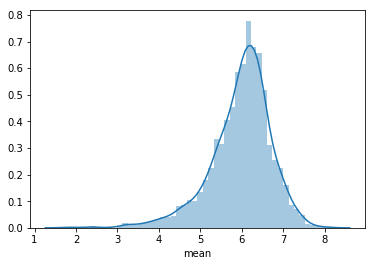

In [ ]:
sns.distplot(final_production_df['mean'])

However, the two communities suggest that there are in fact 2 different distributions. It must be somewhat of a Gaussian Mixture.

In [ ]:
production_group = final_production_df[['mean', 'community']].groupby('community')

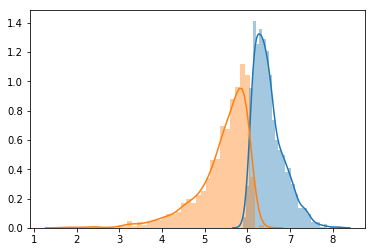

In [ ]:
for g in production_group:
    sns.distplot(g[1]['mean'].values)

In [2]:
# temp = []
# for g in production_group:
#     temp.append(g[1]['mean'].values)
# #scipy.stats.ttest_ind(temp[0], temp[1])

In [ ]:
## Revenue comparison
map_df = movies_df[['id', 'production_companies', 'vote_average', 'budget', 'revenue']]
map_df['production_companies'] = map_df['production_companies'].apply(lambda x: [n['name'] for n in x])
map_df = map_df.explode('production_companies')
map_df.dropna(inplace=True)

map_df = pd.merge(final_production_df, map_df, how='left', left_on='production_company', right_on='production_companies')
map_group = map_df[map_df['revenue']!=0].groupby("community")

temp = []
for g in map_group:
    temp.append(g[1]['revenue'].values)
np.mean(temp[0]), np.mean(temp[1])

(102784865.76955856, 79907003.60742706)

In [1]:
#scipy.stats.ttest_ind(temp[0], temp[1])

In [ ]:
## Relative Difference in revenues
(np.mean(temp[0])-np.mean(temp[1]))/np.mean(temp[1])

0.2863060949516707